In [3]:
from simtk import openmm
from simtk import unit

import numpy as np
from sys import stdout
from openmmtools import integrators
import random
import matplotlib.pyplot as plt
import mdtraj as md
import pickle

In [2]:
# with open('Alanine_dipeptide/ala2_xml_system.txt') as f:
#     xml = f.read()
# system = openmm.XmlSerializer.deserialize(xml)

# for i, f in enumerate(system.getForces()):
#     f.setForceGroup(i)

In [3]:

# #platform 2 = CUDA
# platform = openmm.Platform.getPlatform(2)

# temperature_bg = 300.0 * unit.kelvin
# collision_rate_bg = 1.0 / unit.picosecond
# timestep_bg = 4.0 * unit.femtosecond

In [16]:
def getenergybreakdown(fname, molecule):

    if molecule == 'pro':
        fpath_stub = 'proline'
        top_file = f'{fpath_stub}/cis_pro.pdb'
        system_file = f'{fpath_stub}/noconstraints_xmlsystem.txt'
        
    elif molecule == 'ala2':
        fpath_stub = 'Alanine_dipeptide'
        top_file = 'Alanine_dipeptide/ala2_fromURL.pdb'
        system_file = f'{fpath_stub}/ala2_noconstraints_system.txt'
    else:
        print('molecule not recognised')

    with open(f'{system_file}') as f:
        xml = f.read()
    system = openmm.XmlSerializer.deserialize(xml)

    platform = openmm.Platform.getPlatform(2)

    
        
    try:
        pickleFile = open(f'{fpath_stub}/parameters/parameters{fname}.pkl','rb')
        parametersdict = pickle.load(pickleFile)
        temperature = parametersdict['Temperature']
        collision_rate = parametersdict['Collision rate']
        timestep = parametersdict['Timestep']
    except:
        print(f'{fname} no parameters found')
        if 'coupled' in fname or '1000' in fname:
            print('using 1000K')
            temperature = 1000.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 2.0 * unit.femtosecond
        else:
            print('300K')
            temperature = 300.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 2.0 * unit.femtosecond

    # md_temperature = 1000 * unit.kelvin
    # md_collision_rate = 10 / unit.picosecond
    # md_timestep = 1.0 * unit.femtosecond

    for i, f in enumerate(system.getForces()):
        f.setForceGroup(i)
    
    if 'coupled' in fname:
        trajectory = md.load(f'Coupled_scheme/Trajectories/{fname}.dcd', top='Alanine_dipeptide/ala2_fromURL.pdb')
    else:    
        trajectory = md.load(f'{fpath_stub}/Trajectories/{fname}.dcd', top=f'{top_file}')

    coordinates = trajectory.xyz
    if len(coordinates) > 10000:
        coordinates = coordinates[0:10000]

    integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

    properties_dict = {}
    properties_dict["DeviceIndex"] = "3"

    pdb = openmm.app.PDBFile(f'{top_file}')
    topology = pdb.getTopology()
    
    simulation = openmm.app.Simulation(topology,system,integrator,platform,platformProperties=properties_dict)

    energies = {f.getName():np.zeros((len(coordinates))) for f in system.getForces()}

    for index, positions in enumerate(coordinates):
        simulation.context.setPositions(positions)

        for i, f in enumerate(system.getForces()):
            state = simulation.context.getState(getEnergy=True, groups={i})
            energies[f.getName()][index] = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)

    mins = {f.getName() : energies[f.getName()].min() for f in system.getForces()}
    maxes = {f.getName() : energies[f.getName()].max() for f in system.getForces()}
    
    return energies, mins, maxes, system
    
#var = state.getPotentialEnergy()

In [25]:
print(energies['HarmonicBondForce'])

[16.02735329 26.88512421 26.14590073 ... 37.61485291 33.94455338
 36.28069687]


In [12]:
def plotenergybreakdown(*fnames, molecule):
    fig, axes = plt.subplots(2,3, figsize=(12,6), )
    axes= axes.reshape(-1)
    energies = {}
    mins = {}
    maxes = {}
    for fname in fnames:
        energies[fname], mins[fname], maxes[fname], system = getenergybreakdown(fname, molecule)
        alpha=(1-fnames.index(fname)/5)

        for i, f in enumerate(system.getForces()):
            if energies[fname][f.getName()].max() > 200:
                upper_cut = np.percentile(energies[fname][f.getName()],97)
                print('top end cut', f.getName(), fname)
            else:
                upper_cut = energies[fname][f.getName()].max()

            if energies[fname][f.getName()].min() <-200:
                lower_cut = np.percentile(energies[fname][f.getName()], 3)
                print('bottom end cut', f.getName(), fname)
            else:
                lower_cut = energies[fname][f.getName()].min()
            
            #print(fname, f.getName(), upper_cut,lower_cut)
            # n_bins = 40
            # bins = np.linspace(energies[f.getName()].min(), energies[f.getName()].max(), n_bins)
            # binwidth = 20
            # bins = np.arange(min(mins.values()), max(maxes.values()) + binwidth ,binwidth)

            
            if 'samples' in fname:
                label = 'BG'
            
            elif 'nobias' in fname:
                label = 'Coupled - no bias'
            elif 'expbias' in fname:
                label = 'Coupled - with bias'
            elif 'K' in fname:
                label = 'MD'
            else:
                label = f'{fname}'
            
            axes[i].hist(energies[fname][f.getName()], bins=40, range=(lower_cut, upper_cut), label = f'{label}', alpha=alpha)
            
            axes[i].set_xlabel("Energy   [$kJ$ $mol^{-1}$]")
            axes[i].set_title(f'{f.getName()}')
    axes[2].legend(bbox_to_anchor=(1.04,1), loc='upper left')
    plt.tight_layout()

In [7]:
energies = getenergybreakdown('TSFtraj_xmlsystem_20000KLL_samplestraj')
print(np.percentile(energies['NonbondedForce'], 99))

TypeError: getenergybreakdown() missing 1 required positional argument: 'molecule'

300K_noconstr_long_3_samplestraj no parameters found
300K
top end cut HarmonicBondForce 300K_noconstr_long_3_samplestraj
top end cut HarmonicAngleForce 300K_noconstr_long_3_samplestraj
top end cut PeriodicTorsionForce 300K_noconstr_long_3_samplestraj
top end cut NonbondedForce 300K_noconstr_long_3_samplestraj


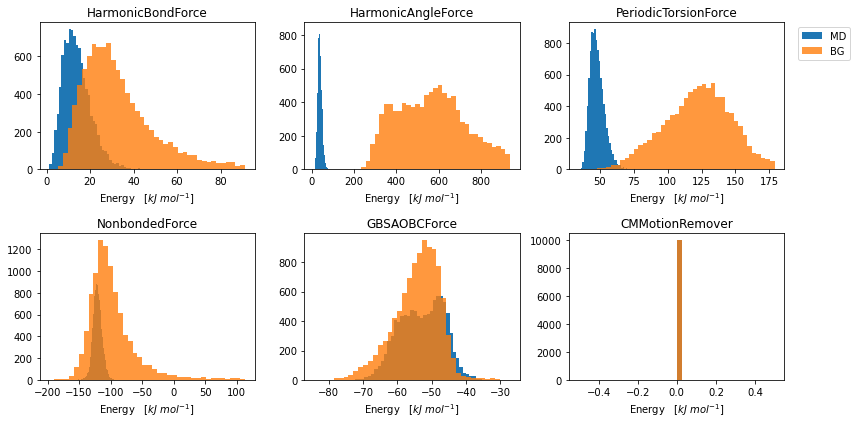

In [15]:
plotenergybreakdown('300K','300K_noconstr_long_3_samplestraj', molecule='ala2')

In [50]:
pdb = openmm.app.PDBFile('proline/cis_pro.pdb')

ff = openmm.app.ForceField("amber99sbildn.xml", "amber96_obc.xml")
new_system = ff.createSystem(
    pdb.getTopology(),
    removeCMMotion=True,
    nonbondedMethod=openmm.app.NoCutoff,
    constraints=None,
    rigidWater=True)

xml = openmm.XmlSerializer.serialize(new_system)
xml_file = open('proline/noconstraints_xmlsystem.txt','w')
xml_file.write(xml)
xml_file.close()

In [51]:
with open(f'proline/noconstraints_xmlsystem.txt') as f:
    xml = f.read()
system = openmm.XmlSerializer.deserialize(xml)

platform = openmm.Platform.getPlatform(2)

md_temperature = 1000 * unit.kelvin
md_collision_rate = 10 / unit.picosecond
md_timestep = 1.0 * unit.femtosecond

for i, f in enumerate(system.getForces()):
    f.setForceGroup(i)

integrator = integrators.LangevinIntegrator(temperature=md_temperature,collision_rate=md_collision_rate,timestep=md_timestep)

properties_dict = {}
properties_dict["DeviceIndex"] = "2"

pdb = openmm.app.PDBFile(f'proline/cis_pro.pdb')
topology = pdb.getTopology()

simulation = openmm.app.Simulation(topology,system,integrator,platform,platformProperties=properties_dict)

In [52]:
traj = md.load('proline/Trajectories/cis_start_long_2_samplestraj.dcd', top='proline/cis_pro.pdb')
positions= traj.xyz[0]

simulation.context.setPositions(positions)

In [53]:
for i, f in enumerate(system.getForces()):
    state = simulation.context.getState(getEnergy=True, groups={i})
    print(f.getName(), state.getPotentialEnergy())

HarmonicBondForce 37942924.0 kJ/mol
HarmonicAngleForce 556.1607055664062 kJ/mol
PeriodicTorsionForce 124.13973999023438 kJ/mol
NonbondedForce 24.17486572265625 kJ/mol
GBSAOBCForce -222.70654296875 kJ/mol
CMMotionRemover 0.0 kJ/mol


In [46]:
totalstate = simulation.context.getState(getEnergy=True)
print(totalstate.getPotentialEnergy())

522.827880859375 kJ/mol
